In [1]:
cd ..

/home/wesg/research/neuron-stats


In [2]:
# autoreload
%load_ext autoreload
%autoreload 2

import os
import pickle
import argparse
import einops
import torch
import numpy as np
import pandas as pd
from transformer_lens import HookedTransformer
from summary_viewer import *
import matplotlib.pyplot as plt
import seaborn as sns
import datasets
import torch
import itertools
from utils import *
from scipy.stats import skew, kurtosis
from analysis.weights import neuron_vocab_cosine_moments
from analysis.vocab_df import *
from analysis.neuron_df import *
from analysis.activations import make_dataset_df
from explain import *

torch.set_grad_enabled(False)

%matplotlib inline

/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.0.6) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [3]:
model_name = 'stanford-gpt2-medium-a'
model = HookedTransformer.from_pretrained(model_name)

decoded_vocab = {
    tix: model.tokenizer.decode(tix)
    for tix in model.tokenizer.get_vocab().values()
}

Using pad_token, but it is not set yet.


Loaded pretrained model stanford-gpt2-medium-a into HookedTransformer


In [4]:
universal_neuron_df = pd.read_csv(f'dataframes/interpretable_neurons/{model_name}/universal.csv')
#subgaussian_neuron_df = pd.read_csv('dataframes/interpretable_neurons/stanford-gpt2-small-a/sub_gaussian_activation_kurtosis.csv')

neuron_df = pd.read_csv(f'dataframes/neuron_dfs/{model_name}.csv')
vocab_df = pd.read_csv('dataframes/vocab_dfs/gpt2.csv')
vocab_df.loc[vocab_df.token_string.isna(), 'token_string'] = 'n/a'

In [5]:
dataset_name = 'pile.test.all-10m.512'
ds = datasets.load_from_disk(os.path.join('token_datasets', 'gpt2', dataset_name))

In [6]:
from analysis.activations import make_dataset_df
from analysis.vocab_df import create_normalized_vocab

dataset_df = make_dataset_df(ds, decoded_vocab)
decoded_norm_vocab, token_ix_2_normed_ix = create_normalized_vocab(vocab_df, decoded_vocab)

In [7]:
dataset_df['normed_token'] = dataset_df['token'].apply(lambda x: token_ix_2_normed_ix[x])

In [8]:
context_var_red_df = pd.concat([
    pd.read_csv(f'results/explanations/stanford-gpt2-medium-a/pile.test.all-10m.512/sequence_feature/layer_{l}/variance_reduction.csv',
     dtype={'neuron': str}).set_index('neuron') for l in range(24)
], axis=0)

token_var_red_df = pd.concat([
    pd.read_csv(f'results/explanations/stanford-gpt2-medium-a/pile.test.all-10m.512/token_feature/layer_{l}/variance_reduction.csv',
     dtype={'neuron': str}).set_index('neuron') for l in range(24)
], axis=0)

prev_token_context_var_red_df = pd.concat([
    pd.read_csv(f'results/explanations/stanford-gpt2-medium-a/pile.test.all-10m.512/sequence_feature/layer_{l}/prev_token_variance_reduction.csv',
        dtype={'neuron': str}).set_index('neuron') for l in range(24)
], axis=0)
prev_token_context_var_red_df = prev_token_context_var_red_df.rename(
    columns={c: 'prev_' + c for c in prev_token_context_var_red_df.columns})

prev_token_var_red_df = pd.concat([
    pd.read_csv(f'results/explanations/stanford-gpt2-medium-a/pile.test.all-10m.512/token_feature/layer_{l}/prev_token_variance_reduction.csv',
    dtype={'neuron': str}).set_index('neuron') for l in range(24)
], axis=0)

prev_token_var_red_df = prev_token_var_red_df.rename(
    columns={c: 'prev_' + c for c in prev_token_var_red_df.columns})

In [9]:
var_red_df = pd.concat([context_var_red_df, token_var_red_df, prev_token_context_var_red_df, prev_token_var_red_df], axis=1)

In [10]:
best_df = pd.concat([var_red_df.max(axis=1), var_red_df.idxmax(axis=1)], axis=1)\
    .sort_values(by=0, ascending=False)\
    .rename(columns={0: 'variance_reduction', 1: 'feature'})\
    .reset_index()

best_df['layer'] = best_df['neuron'].apply(lambda x: int(x.split('.')[0]))
best_df['neuron'] = best_df['neuron'].apply(lambda x: int(x.split('.')[1]))
best_df = best_df[['layer', 'neuron', 'variance_reduction', 'feature']]

In [11]:
join_df = neuron_df.join(best_df.set_index(['layer', 'neuron']), on=['layer', 'neuron'], how='inner').sort_values('variance_reduction', ascending=False)#.query('layer == 9').style.background_gradient(axis=0)
join_df.head(20).style.background_gradient(axis=0)

,layer,neuron,max_corr,mean_corr,min_corr,max_baseline,min_baseline,mean_baseline,w_in_norm,input_bias,w_out_norm,in_out_sim,l2_penalty,mean,var,skew,kurt,vocab_mean,vocab_var,vocab_skew,vocab_kurt,sparsity,variance_reduction,feature
3270,0,3270,0.995000,0.988225,0.968300,0.313700,0.258800,0.285700,0.341519,-0.458929,0.419560,-0.093457,0.292665,-0.615681,0.320870,6.185521,49.890865,-0.000083,0.001459,1.003831,6.778793,0.034329,0.986861,to_unigram
4027,0,4027,0.988300,0.965775,0.944300,0.261200,0.234100,0.247425,0.382962,-0.517760,0.410381,-0.051761,0.315072,-0.672537,0.266199,6.221529,52.153736,-0.000507,0.001019,0.493277,4.599477,0.027697,0.976100,in_unigram
3954,0,3954,0.978000,0.960575,0.941000,0.214800,0.160500,0.188000,0.376250,-0.492060,0.388862,-0.043645,0.292778,-0.897537,0.209004,4.159611,37.739380,0.000471,0.000870,0.108079,3.366423,0.026092,0.969911,for_unigram
3953,0,3953,0.998000,0.995650,0.993000,0.388000,0.362000,0.377675,0.338841,-0.464002,0.424265,-0.161833,0.294814,-0.451912,0.500945,4.423555,23.642336,0.000136,0.000908,0.283957,3.825266,0.065130,0.967139,contains_comma
4212,1,116,0.975600,0.967725,0.949000,0.300300,0.239100,0.278000,0.420413,-1.046302,0.363043,0.529294,0.308547,-1.293949,0.300287,3.174604,21.453880,-0.000011,0.001475,1.345210,7.782014,0.014410,0.962920,to_unigram
3825,0,3825,0.957500,0.930025,0.888000,0.254400,0.221600,0.239400,0.380227,-0.486248,0.393062,-0.056488,0.299070,-0.568703,0.236762,4.338547,30.661678,-0.000099,0.001831,-0.548477,3.418531,0.057021,0.957958,a_unigram
6600,1,2504,0.972700,0.876925,0.700000,0.308000,0.264400,0.286700,0.406215,-0.972122,0.382917,0.591598,0.311636,-1.094341,0.340599,3.758569,22.738125,0.000212,0.001027,0.336573,3.769807,0.026217,0.955042,is_one_digit
891,0,891,0.977000,0.972650,0.968000,0.362000,0.283200,0.312700,0.337752,-0.339625,0.369809,-0.018560,0.250835,-0.519705,0.203219,4.106842,26.781069,0.000012,0.000950,0.018223,2.995720,0.073962,0.954941,of_unigram
2962,0,2962,0.995000,0.994000,0.992700,0.360600,0.328100,0.342450,0.315865,-0.497963,0.397345,0.020245,0.257653,-0.564270,0.503282,3.830324,19.183449,-0.000229,0.001483,0.636134,4.818747,0.060182,0.949867,contains_period
4641,1,545,0.985400,0.971375,0.952600,0.360800,0.340000,0.350975,0.485292,-1.178853,0.344364,0.474745,0.354095,-1.271540,0.593618,2.804875,14.286317,0.000281,0.001455,0.184837,3.572542,0.031211,0.946422,the_unigram


In [12]:
best_df.query('feature == "is_subset_pubmed_abstracts"').sort_values('variance_reduction').tail(20)

,layer,neuron,variance_reduction,feature
866,18,3429,0.055738,is_subset_pubmed_abstracts


In [13]:
join_df.query('variance_reduction < 0.05')

,layer,neuron,max_corr,mean_corr,min_corr,max_baseline,min_baseline,mean_baseline,w_in_norm,input_bias,...,var,skew,kurt,vocab_mean,vocab_var,vocab_skew,vocab_kurt,sparsity,variance_reduction,feature
90239,22,127,0.8794,0.825550,0.7812,0.19360,0.17810,0.184325,0.405880,-0.390727,...,0.513007,1.117384,4.907575,-0.000597,0.000652,-1.983840,21.871357,0.083645,0.049933,is_spacy_pobj
70135,17,503,0.7240,0.677475,0.6123,0.14710,0.13390,0.138575,0.711143,-0.403130,...,0.477584,0.721947,4.826150,0.000149,0.000823,1.469243,14.092446,0.028873,0.049812,after_unigram
59462,14,2118,0.8300,0.772750,0.7010,0.14610,0.13650,0.140875,0.648560,-0.423495,...,0.407234,1.107437,6.220464,-0.000051,0.000685,0.006419,3.263831,0.029739,0.049737,contains_comma
46220,11,1164,0.6865,0.603425,0.4675,0.10030,0.09784,0.099010,0.637955,-0.262992,...,0.371147,0.119298,4.409949,-0.000175,0.000891,0.049592,2.984995,0.029889,0.049722,is_spacy_cc
78571,19,747,0.7554,0.640075,0.5625,0.09076,0.07983,0.083845,0.648178,-0.220085,...,0.374909,0.702532,7.032017,0.000078,0.000555,1.691423,29.754435,0.099680,0.049482,prev_contains_period
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40880,9,4016,0.7773,0.723600,0.6724,0.20600,0.17350,0.188300,0.241325,-0.006135,...,0.289945,-0.437393,3.164904,-0.000595,0.000836,0.060647,3.105763,0.329181,0.015221,starts_w_space
8409,2,217,0.9463,0.894175,0.8560,0.37920,0.35200,0.368175,0.180687,-0.230875,...,1.335041,-0.076813,1.529113,0.000706,0.001123,0.051234,3.660324,0.289822,0.013151,small_norm
2485,0,2485,0.9820,0.975425,0.9717,0.47270,0.43400,0.447175,0.250387,0.107224,...,0.902956,0.615585,2.213105,0.000412,0.000569,-0.052270,2.984649,0.332988,0.011399,prev_start_w_aero
4126,1,30,0.8010,0.753100,0.7134,0.26540,0.23300,0.251125,0.208536,-0.458143,...,0.091391,0.280468,2.727112,0.000327,0.000799,-0.030064,3.052690,0.024023,0.007632,all_digits


In [14]:
feature_set = best_df.feature.unique()
prev_features = [c for c in feature_set if c.startswith('prev_')]
subset_features = [c for c in feature_set if c.startswith('is_subset')]
unigram_features = [c for c in feature_set if c.endswith('unigram')]
spacy_features = [c for c in feature_set if c.startswith('spacy')]

In [31]:
join_df['is_prediction_neuron'] = join_df['vocab_kurt'] > 10

In [34]:
join_df.groupby('is_prediction_neuron').layer.value_counts().sort_index().unstack().T

is_prediction_neuron,False,True
layer,,
0,132.0,NaN
1,140.0,NaN
2,44.0,NaN
3,40.0,NaN
4,40.0,NaN
5,28.0,2.0
6,23.0,NaN
7,21.0,NaN
8,26.0,NaN


In [37]:
(join_df['max_corr'] - join_df['min_corr']).mean()

0.10532109181141433

In [50]:
df = ndfs['stanford-gpt2-medium-a']

In [52]:
df.query('layer==1 and neuron==1716')

,layer,neuron,max_corr,mean_corr,min_corr,max_baseline,min_baseline,mean_baseline,w_in_norm,input_bias,...,mean,var,skew,kurt,vocab_mean,vocab_var,vocab_skew,vocab_kurt,sparsity,excess_corr
5812,1,1716,0.7617,0.695625,0.5938,0.3008,0.2747,0.28865,0.484787,-0.818231,...,-1.057894,0.326555,1.281103,4.909777,-0.000109,0.001071,-0.167292,3.235132,0.081356,0.406975


In [39]:
join_df['excess_corr'] = join_df['mean_corr'] - join_df['mean_baseline']
(join_df.query('excess_corr>0.5')['max_corr'] - join_df.query('excess_corr>0.5')['min_corr']).mean()

0.10532109181141433

In [44]:
(ndfs['stanford-gpt2-medium-a']['max_corr'] - ndfs['stanford-gpt2-medium-a']['min_corr']).mean()

0.04920747601318414

In [5]:
model_names = ['stanford-gpt2-small-a', 'stanford-gpt2-medium-a', 'pythia-160m']
ndfs = {}
for model_name in model_names:
    neuron_df = pd.read_csv(f'dataframes/neuron_dfs/{model_name}.csv')
    neuron_df['excess_corr'] = neuron_df['mean_corr'] - neuron_df['mean_baseline']
    ndfs[model_name] = neuron_df

In [8]:
for name, df in ndfs.items():
    print(name)
    print((df['excess_corr'] > 0.5).mean() * 100)


stanford-gpt2-small-a
4.158528645833334
stanford-gpt2-medium-a
1.2318929036458335
pythia-160m
1.2613932291666665


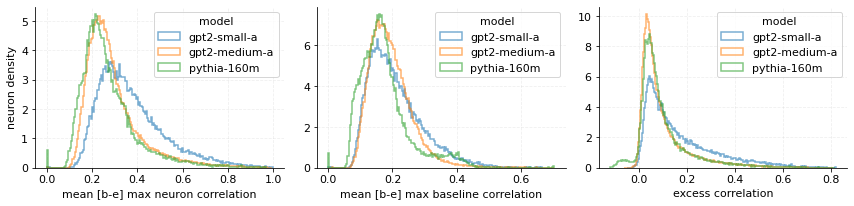

In [7]:
# change fontsize to 11
plt.rc('font', size=11)

fig, axs = plt.subplots(1, 3, figsize=(12, 3))

for j, col in enumerate(['mean_corr', 'mean_baseline', 'excess_corr']):
    for i, model_name in enumerate(model_names):
        neuron_df = ndfs[model_name]
        # plot histogram without filling
        axs[j].hist(
            neuron_df[col], alpha=0.6, label=model_name.replace('stanford-', ''), 
            bins=200, density=True, histtype='step', linewidth=1.5)
    if j == 0:
        axs[j].set_ylabel('neuron density')


    axs[j].grid(alpha=0.2, linestyle='--')
    axs[j].spines['right'].set_visible(False)
    axs[j].spines['top'].set_visible(False)
    axs[j].legend(title='model')

axs[0].set_xlabel('mean [b-e] max neuron correlation')
axs[1].set_xlabel('mean [b-e] max baseline correlation')
axs[2].set_xlabel('excess correlation')

plt.tight_layout()

plt.savefig('figures/neuron_correlation_densities.png', bbox_inches='tight', dpi=100)

In [20]:
model_name = 'pythia-160m'

save_path = os.path.join('dataframes', 'interpretable_neurons', model_name)
os.makedirs(save_path, exist_ok=True)

ndfs[model_name].query('excess_corr > 0.5').to_csv(os.path.join(save_path, 'universal.csv'), index=False)

In [21]:
model_name = 'stanford-gpt2-small-a'

save_path = os.path.join('dataframes', 'interpretable_neurons', model_name)
os.makedirs(save_path, exist_ok=True)

ndfs[model_name].query('excess_corr > 0.5').to_csv(os.path.join(save_path, 'universal.csv'), index=False)